In [1]:
# CNN with 7 days window size
%matplotlib inline
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


import pandas as pd
import numpy as np
import shutil
import os
import collections
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error,r2_score

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
def to_sequences(seq_size, data):
    x = []
    y = []
#data has individual records but you want your model to be based on a sequence of days. 
    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)    


#Print stats and plots for a model
def model_report(pred,y_test,labels):
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Score (RMSE): {}".format(score))
    chart_regression(pred.flatten(),y_test)
    
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [2]:
    
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

df = pd.read_csv("./data/CSC215_P2_Stock_Price.csv")
df.drop(columns=['Adj_Close'], inplace=True)
df['Date']= pd.to_datetime(df['Date']) 
df.sort_values(by=['Date'])
dfclose = df['Close'].copy(deep=True)
encode_numeric_range(df,'Open')
encode_numeric_range(df,'High')
encode_numeric_range(df,'Low')
encode_numeric_range(df,'Close')
encode_numeric_range(df,'Volume')
df.insert(6,'True_Close',dfclose)
#split along year, for sequential analysis
#dftrain=df[df['Date']<='2010/12/31']
#dftest=df[df['Date']>='2011/01/01']
print(df.shape)
df[0:1]


# Split into train/test
import math
# Split into train/test
size = df.shape[0]
print(size)
trainsize= math.floor(size*.7)
dftrain = df.head(trainsize)
dftest = df.tail(size-trainsize)
#print("dftrain is{}")
#print("{}".format(dftrain[0:16]))

SEQUENCE_SIZE=7;

dftrain_yonly=dftrain[['Date','True_Close']]
dftest_yonly=dftest[['Date','True_Close']]
dftrain_yonly.drop(columns=['Date'], inplace=True)
dftest_yonly.drop(columns=['Date'],inplace=True)
dftrain.drop(columns=['Date','True_Close'], inplace=True)
dftest.drop(columns=['Date','True_Close'], inplace=True)
data = dftrain.to_numpy()
datay = dftrain_yonly.to_numpy()
x_train,y_train = to_sequences(SEQUENCE_SIZE,data)
xthrow,y_train = to_sequences(SEQUENCE_SIZE,datay)
print("Shape of xtrain b4 {}" .format(x_train.shape))
print("Shape of ytrain b4{}" .format(y_train.shape))
data = dftest.to_numpy()
datay = dftest_yonly.to_numpy()
x_test,y_test = to_sequences(SEQUENCE_SIZE,data)
xthrowaway,y_test = to_sequences(SEQUENCE_SIZE,datay)

#print("x train is {}" )
#print(x_train[0:16])
#print("y train is {}")
#print(y_train[0:16])

print("Shape of xtest b4 {}" .format(x_test.shape))

x_train = np.reshape(x_train,(x_train.shape[0],7,5,1)) #x_train = np.reshape(x,(x.shape[0],x.shape[1],x.shape[3]))
x_test = np.reshape(x_test,(x_test.shape[0],7,5,1))

#print("lastx train test")
#x_train = np.reshape(x_train,(x_train.shape[0],7,5)) #x_train = np.reshape(x,(x.shape[0],x.shape[1],x.shape[3]))
#x_test = np.reshape(x_test,(x_test.shape[0],7,5))

print(x_test.shape)
print("Shape of ytest b4{}" .format(y_test.shape))
print(x_train.shape)
print("Shape of ytrain b4{}" .format(y_train.shape))


(4392, 7)
4392


C:\Users\Mochu\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Shape of xtrain b4 (3066, 7, 1, 5)
Shape of ytrain b4(3066, 1)
Shape of xtest b4 (1310, 7, 1, 5)
(1310, 7, 5, 1)
Shape of ytest b4(1310, 1)
(3066, 7, 5, 1)
Shape of ytrain b4(3066, 1)


0
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 5167.95785, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 2s - loss: 319.9375 - val_loss: 5167.9578
Epoch 2/10

Epoch 00002: val_loss improved from 5167.95785 to 4592.13192, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 207.0430 - val_loss: 4592.1319
Epoch 3/10

Epoch 00003: val_loss improved from 4592.13192 to 4584.73501, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 167.4296 - val_loss: 4584.7350
Epoch 4/10

Epoch 00004: val_loss improved from 4584.73501 to 4318.38156, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 155.7327 - val_loss: 4318.3816
Epoch 5/10

Epoch 00005: val_loss improved from 4318.38156 to 3845.49067, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 141.3405 - val_loss: 3845.4907
Epoch 6/10

Epoch 00006: val_loss improved from 3845.49067 to 2976.04517

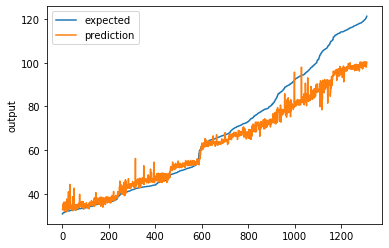

In [15]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn_es.hdf5", verbose=1, save_best_only=True)

for i in range(2):
    print(i)
    
    model_cnn = Sequential()
    model_cnn.add(Conv2D(32, kernel_size=(1, 4), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(7,5,1)))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train, y_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test, y_test))
print('Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn_es.hdf5')
pred_cnn = model_cnn.predict(x_test)
pred_cnn.flatten()

chart_regression(pred_cnn.flatten(),y_test)

score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test)
print("Score (R2): {}".format(score_cnn_r2))

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 5300.60909, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 2s - loss: 339.7116 - val_loss: 5300.6091
Epoch 2/10

Epoch 00002: val_loss improved from 5300.60909 to 5287.81312, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 337.3195 - val_loss: 5287.8131
Epoch 3/10

Epoch 00003: val_loss improved from 5287.81312 to 5252.85809, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 332.8293 - val_loss: 5252.8581
Epoch 4/10

Epoch 00004: val_loss improved from 5252.85809 to 4627.13293, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 1s - loss: 242.0526 - val_loss: 4627.1329
Epoch 5/10

Epoch 00005: val_loss improved from 4627.13293 to 4475.68795, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 167.7830 - val_loss: 4475.6879
Epoch 6/10

Epoch 00006: val_loss improved from 4475.68795 to 4033.52537

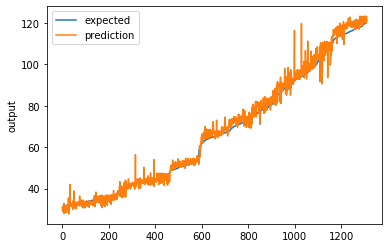

Score (RMSE): 3.0227406297257122
Score (R2): 0.9890746919976798


In [18]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn_es.hdf5", verbose=1, save_best_only=True)

for i in range(2):
    print(i)
    
    model_cnn = Sequential()
    model_cnn.add(Conv2D(64, kernel_size=(2,3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(7,5,1)))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train, y_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test, y_test))
print('Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn_es.hdf5')
pred_cnn = model_cnn.predict(x_test)
pred_cnn.flatten()

chart_regression(pred_cnn.flatten(),y_test)

score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test)
print("Score (R2): {}".format(score_cnn_r2))

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 5207.81087, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 2s - loss: 325.1420 - val_loss: 5207.8109
Epoch 2/10

Epoch 00002: val_loss improved from 5207.81087 to 4711.06714, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 210.4468 - val_loss: 4711.0671
Epoch 3/10

Epoch 00003: val_loss improved from 4711.06714 to 4616.91989, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 168.2963 - val_loss: 4616.9199
Epoch 4/10

Epoch 00004: val_loss improved from 4616.91989 to 4256.60853, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 154.6616 - val_loss: 4256.6085
Epoch 5/10

Epoch 00005: val_loss improved from 4256.60853 to 3496.66591, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 134.9336 - val_loss: 3496.6659
Epoch 6/10

Epoch 00006: val_loss improved from 3496.66591 to 1795.80149

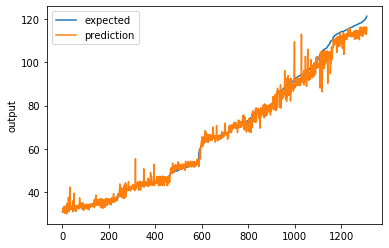

Score (RMSE): 2.8892231419281096
Score (R2): 0.9880359041313129


In [19]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn_es.hdf5", verbose=1, save_best_only=True)

for i in range(2):
    print(i)
    
    model_cnn = Sequential()
    model_cnn.add(Conv2D(128, kernel_size=(1, 4), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(7,5,1)))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train, y_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test, y_test))
print('Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn_es.hdf5')
pred_cnn = model_cnn.predict(x_test)
pred_cnn.flatten()

chart_regression(pred_cnn.flatten(),y_test)

score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test)
print("Score (R2): {}".format(score_cnn_r2))

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 4601.66162, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 3s - loss: 266.4445 - val_loss: 4601.6616
Epoch 2/10

Epoch 00002: val_loss improved from 4601.66162 to 4351.29971, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 1s - loss: 171.2450 - val_loss: 4351.2997
Epoch 3/10

Epoch 00003: val_loss improved from 4351.29971 to 3639.39806, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 1s - loss: 145.9061 - val_loss: 3639.3981
Epoch 4/10

Epoch 00004: val_loss improved from 3639.39806 to 1659.72565, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 1s - loss: 104.7231 - val_loss: 1659.7257
Epoch 5/10

Epoch 00005: val_loss improved from 1659.72565 to 202.24934, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 1s - loss: 21.0363 - val_loss: 202.2493
Epoch 6/10

Epoch 00006: val_loss improved from 202.24934 to 24.03422, savi

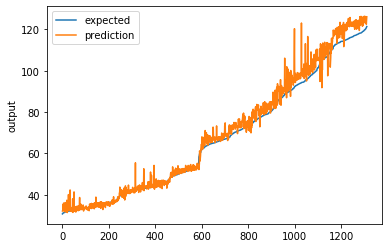

Score (RMSE): 3.8790680585073627
Score (R2): 0.982882568302215


In [25]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn_es.hdf5", verbose=1, save_best_only=True)

for i in range(2):
    print(i)
    
    model_cnn = Sequential()
    model_cnn.add(Conv2D(512, kernel_size=(1, 2), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(7,5,1)))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train, y_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test, y_test))
print('Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn_es.hdf5')
pred_cnn = model_cnn.predict(x_test)
pred_cnn.flatten()

chart_regression(pred_cnn.flatten(),y_test)

score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test)
print("Score (R2): {}".format(score_cnn_r2))

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 5186.64606, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 2s - loss: 317.7286 - val_loss: 5186.6461
Epoch 2/10

Epoch 00002: val_loss improved from 5186.64606 to 4728.72112, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 218.5230 - val_loss: 4728.7211
Epoch 3/10

Epoch 00003: val_loss improved from 4728.72112 to 4683.90151, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 173.5109 - val_loss: 4683.9015
Epoch 4/10

Epoch 00004: val_loss improved from 4683.90151 to 4528.60350, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 165.2519 - val_loss: 4528.6035
Epoch 5/10

Epoch 00005: val_loss improved from 4528.60350 to 4356.28938, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 158.0038 - val_loss: 4356.2894
Epoch 6/10

Epoch 00006: val_loss improved from 4356.28938 to 4098.22794

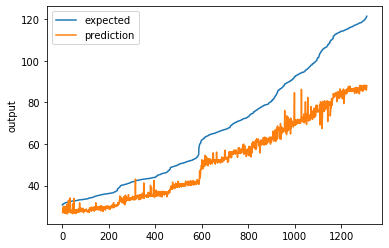

Score (RMSE): 17.280653158895788
Score (R2): 0.21324999289188884


In [26]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn_es.hdf5", verbose=1, save_best_only=True)

for i in range(2):
    print(i)
    
    model_cnn = Sequential()
    model_cnn.add(Conv2D(16, kernel_size=(1, 4), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(7,5,1)))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train, y_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test, y_test))
print('Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn_es.hdf5')
pred_cnn = model_cnn.predict(x_test)
pred_cnn.flatten()

chart_regression(pred_cnn.flatten(),y_test)

score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test)
print("Score (R2): {}".format(score_cnn_r2))

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 5154.72959, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 2s - loss: 317.8863 - val_loss: 5154.7296
Epoch 2/10

Epoch 00002: val_loss improved from 5154.72959 to 4836.07306, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 1s - loss: 186.0728 - val_loss: 4836.0731
Epoch 3/10

Epoch 00003: val_loss improved from 4836.07306 to 4505.55138, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 1s - loss: 161.8075 - val_loss: 4505.5514
Epoch 4/10

Epoch 00004: val_loss improved from 4505.55138 to 3528.40864, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 1s - loss: 139.0834 - val_loss: 3528.4086
Epoch 5/10

Epoch 00005: val_loss improved from 3528.40864 to 1173.08482, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 1s - loss: 88.2770 - val_loss: 1173.0848
Epoch 6/10

Epoch 00006: val_loss improved from 1173.08482 to 109.03804, 

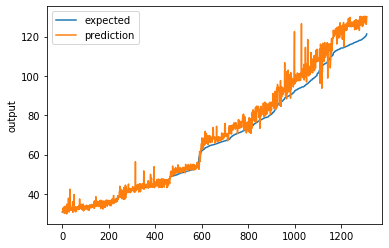

Score (RMSE): 5.282383612137701
Score (R2): 0.9709047495251331


In [28]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn_es.hdf5", verbose=1, save_best_only=True)

for i in range(2):
    print(i)
    
    model_cnn = Sequential()
    model_cnn.add(Conv2D(1025, kernel_size=(1,4), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(7,5,1)))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train, y_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test, y_test))
print('Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn_es.hdf5')
pred_cnn = model_cnn.predict(x_test)
pred_cnn.flatten()

chart_regression(pred_cnn.flatten(),y_test)

score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test)
print("Score (R2): {}".format(score_cnn_r2))

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 3221.62286, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 1s - loss: 194.3175 - val_loss: 3221.6229
Epoch 2/10

Epoch 00002: val_loss did not improve from 3221.62286
3066/3066 - 0s - loss: 123.3003 - val_loss: 3493.3504
Epoch 3/10

Epoch 00003: val_loss did not improve from 3221.62286
3066/3066 - 0s - loss: 118.6948 - val_loss: 3413.7923
Epoch 4/10

Epoch 00004: val_loss improved from 3221.62286 to 3213.42707, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 114.4317 - val_loss: 3213.4271
Epoch 5/10

Epoch 00005: val_loss improved from 3213.42707 to 3024.47567, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 108.6558 - val_loss: 3024.4757
Epoch 6/10

Epoch 00006: val_loss improved from 3024.47567 to 2627.36286, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 99.2144 - val_loss: 2627.3629
Epoch 7/10

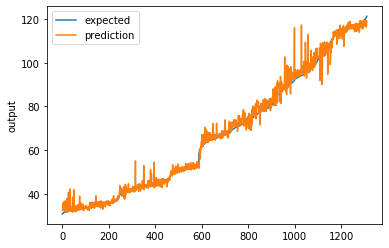

Score (RMSE): 2.681912924294203
Score (R2): 0.9907794430244428


In [4]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn_es.hdf5", verbose=1, save_best_only=True)

for i in range(2):
    print(i)
    
    model_cnn = Sequential()
    model_cnn.add(Conv2D(64, kernel_size=(2,3), strides=(1, 1), padding='valid',
                 activation='sigmoid',
                 input_shape=(7,5,1)))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train, y_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test, y_test))
print('Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn_es.hdf5')
pred_cnn = model_cnn.predict(x_test)
pred_cnn.flatten()

chart_regression(pred_cnn.flatten(),y_test)

score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test)
print("Score (R2): {}".format(score_cnn_r2))

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 5080.03491, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 1s - loss: 293.9914 - val_loss: 5080.0349
Epoch 2/10

Epoch 00002: val_loss improved from 5080.03491 to 4900.62240, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 177.9887 - val_loss: 4900.6224
Epoch 3/10

Epoch 00003: val_loss improved from 4900.62240 to 4651.20533, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 164.5771 - val_loss: 4651.2053
Epoch 4/10

Epoch 00004: val_loss improved from 4651.20533 to 4118.48993, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 149.0755 - val_loss: 4118.4899
Epoch 5/10

Epoch 00005: val_loss improved from 4118.48993 to 2627.41108, saving model to ./best_weights_stock_cnn_es.hdf5
3066/3066 - 0s - loss: 117.4392 - val_loss: 2627.4111
Epoch 6/10

Epoch 00006: val_loss improved from 2627.41108 to 138.25668,

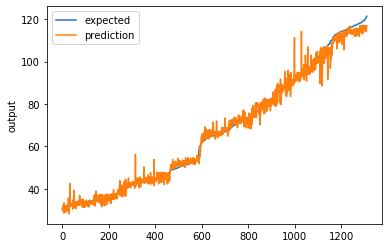

Score (RMSE): 2.643869778405379
Score (R2): 0.9904401836174637


In [5]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn_es.hdf5", verbose=1, save_best_only=True)

for i in range(2):
    print(i)
    
    model_cnn = Sequential()
    model_cnn.add(Conv2D(64, kernel_size=(2,3), strides=(1, 1), padding='valid',
                 activation='tanh',
                 input_shape=(7,5,1)))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train, y_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test, y_test))
print('Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn_es.hdf5')
pred_cnn = model_cnn.predict(x_test)
pred_cnn.flatten()

chart_regression(pred_cnn.flatten(),y_test)

score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test)
print("Score (R2): {}".format(score_cnn_r2))

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss did not improve from inf
3066/3066 - 2s - loss: nan - val_loss: nan


C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/10

Epoch 00002: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 3/10

Epoch 00003: val_loss did not improve from inf
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 4/10

Epoch 00004: val_loss did not improve from inf
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 5/10

Epoch 00005: val_loss did not improve from inf
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 00005: early stopping
1
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss did not improve from inf
3066/3066 - 2s - loss: nan - val_loss: nan


C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/10

Epoch 00002: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 3/10

Epoch 00003: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 4/10

Epoch 00004: val_loss did not improve from inf
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 5/10

Epoch 00005: val_loss did not improve from inf
3066/3066 - 1s - loss: nan - val_loss: nan
Epoch 00005: early stopping
Loading the best model



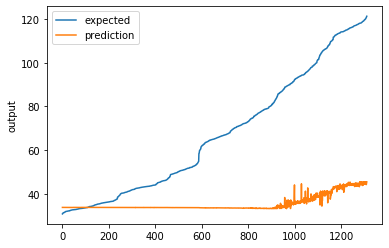

Score (RMSE): 40.64580970142778
Score (R2): -134.179829428477


In [12]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn_es.hdf5", verbose=1, save_best_only=True)

for i in range(2):
    print(i)
    
    model_cnn = Sequential()
    model_cnn.add(Conv2D(64, kernel_size=(2,3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=(7,5,1)))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train, y_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test, y_test))
print('Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn_es.hdf5')
pred_cnn = model_cnn.predict(x_test)
pred_cnn.flatten()

chart_regression(pred_cnn.flatten(),y_test)

score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test)
print("Score (R2): {}".format(score_cnn_r2))

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss did not improve from inf
3066/3066 - 1s - loss: nan - val_loss: nan


C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/10

Epoch 00002: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 3/10

Epoch 00003: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 4/10

Epoch 00004: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 5/10

Epoch 00005: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 00005: early stopping
1
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss did not improve from inf
3066/3066 - 1s - loss: nan - val_loss: nan


C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/10

Epoch 00002: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 3/10

Epoch 00003: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 4/10

Epoch 00004: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 5/10

Epoch 00005: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 00005: early stopping
Loading the best model



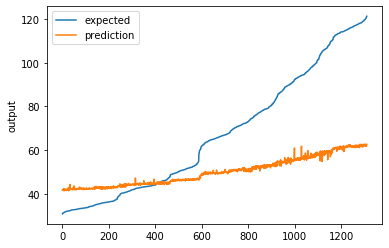

Score (RMSE): 27.498622388770244
Score (R2): -17.286142871293002


In [7]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn_es.hdf5", verbose=1, save_best_only=True)

for i in range(2):
    print(i)
    
    model_cnn = Sequential()
    model_cnn.add(Conv2D(64, kernel_size=(2,3), strides=(1, 1), padding='valid',
                 activation='sigmoid',
                 input_shape=(7,5,1)))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train, y_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test, y_test))
print('Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn_es.hdf5')
pred_cnn = model_cnn.predict(x_test)
pred_cnn.flatten()

chart_regression(pred_cnn.flatten(),y_test)

score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test)
print("Score (R2): {}".format(score_cnn_r2))

0
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss did not improve from inf
3066/3066 - 1s - loss: nan - val_loss: nan


C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/10

Epoch 00002: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 3/10

Epoch 00003: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 4/10

Epoch 00004: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 5/10

Epoch 00005: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 00005: early stopping
1
Train on 3066 samples, validate on 1310 samples
Epoch 1/10

Epoch 00001: val_loss did not improve from inf
3066/3066 - 1s - loss: nan - val_loss: nan


C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:1225: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\Mochu\Anaconda3\lib\site-packages\tensorflow_core\python\keras\callbacks.py:992: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/10

Epoch 00002: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 3/10

Epoch 00003: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 4/10

Epoch 00004: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 5/10

Epoch 00005: val_loss did not improve from inf
3066/3066 - 0s - loss: nan - val_loss: nan
Epoch 00005: early stopping
Loading the best model



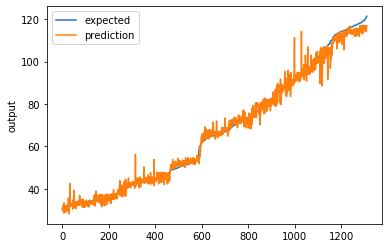

Score (RMSE): 2.643869778405379
Score (R2): 0.9904401836174637


In [8]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_stock_cnn_es.hdf5", verbose=1, save_best_only=True)

for i in range(2):
    print(i)
    
    model_cnn = Sequential()
    model_cnn.add(Conv2D(64, kernel_size=(2,3), strides=(1, 1), padding='valid',
                 activation='tanh',
                 input_shape=(7,5,1)))
    model_cnn.add(Conv2D(64, (1, 1), activation='relu'))
    model_cnn.add(MaxPooling2D(pool_size=(1, 1), strides=None))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.add(Dense(10, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_cnn.fit(x_train, y_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_test, y_test))
print('Loading the best model') 
print()
model_cnn.load_weights('./best_weights_stock_cnn_es.hdf5')
pred_cnn = model_cnn.predict(x_test)
pred_cnn.flatten()

chart_regression(pred_cnn.flatten(),y_test)

score_cnn= np.sqrt(mean_squared_error(pred_cnn,y_test))
print("Score (RMSE): {}".format(score_cnn))
score_cnn_r2= r2_score(pred_cnn,y_test)
print("Score (R2): {}".format(score_cnn_r2))